In [52]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm
import unidecode

import matplotlib as mpl
font = {        'size'   : 20}
mpl.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import imageio

In [2]:
# Getting the top 19 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]
iwiw_code_dict= {379: 'Budapest', 380: 'Debrecen', 381: 'Miskolc', 382: 'Szeged', 383: 'Pecs', 384: 'Gyor', 385: 'Nyiregyhaza', 386: 'Kecskemet',
 387: 'Szekesfehervar', 388: 'Szombathely', 389: 'Szolnok', 390: 'Tatabanya', 391: 'Kaposvar', 392: 'Bekescsaba', 393: 'Zalaegerszeg',
 394: 'Veszprem', 396: 'Eger', 1842: 'Szekszard', 2103: 'Salgotarjan'}
city_to_code = {v:k for k,v in iwiw_code_dict.items()}

# useful masks
mask_SL_t = ~np.eye(19,dtype=bool) # mask for self loops in a snapshot
mask_SL = np.array([mask_SL_t]*11) # mask for self loops across all snapshots

In [3]:
def remove_accent(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

def names_to_ids(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')).applymap(lambda x: city_to_code[x])

def users_per_city(W):
    n = np.zeros([W.shape[0],W.shape[1]],dtype='int')
    for t in range(W.shape[0]):
        n[t,:] = np.sum(W[0,:,:],axis=1) + np.sum(W[0:t+1,:,:],axis=(0,2))
    n[n==0]+=1 # artificially ensuring no cities have 0 users!
    return n  

# Reading infrastructural data

In [4]:
shortest_paths = pd.read_csv('../simplified_roads/hungary/data/shortest_paths.csv')
shortest_paths[['source','target']]=names_to_ids(shortest_paths[['source','target']])
shortest_paths['length'] = shortest_paths['length'].apply(lambda x:x/1000)

node_list=shortest_paths['source'].unique() # all the unique nodes
Years=shortest_paths['year'].unique() # all the unique years

# Turning dataframe into usable nx networks
graphs = {y:nx.from_pandas_edgelist(shortest_paths[shortest_paths['year']==y],
                                    source='source',target='target',edge_attr=['travel_time','length'],) 
          for y in Years}

# Turning nx networks into adjacency matrices (tensors) of travel time and distances
travel_time_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='travel_time') for y in Years])
length_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='length') for y in Years])

# Reading social data

In [5]:
connections = pd.read_csv('../analysis/all_spatiosocial_data.csv')
graphs_S = {y:nx.from_pandas_edgelist(connections[connections['Year']==y],
                                    source='CityID_From',target='CityID_To',edge_attr='Connections') 
          for y in Years}

S = np.array([nx.to_numpy_array(graphs_S[y],dtype=np.float32,weight='Connections') for y in Years])

# Reconstructing W tensor which has not been saved as a data file
invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
reduced_df = invitations_iwiw[mask1&mask2]
graphs_W = {year:nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                                        source='InvitorCityId',target='CityId',edge_attr='w',
                                                        create_using=nx.DiGraph)
            for year in Years}

# asymmetric, weighted tensor of size T x N x N
W = np.array([nx.to_numpy_array(graphs_W[y],dtype=np.float32,weight='w') for y in Years])
for i in range(W.shape[1]):
    W[:,i,i]=0

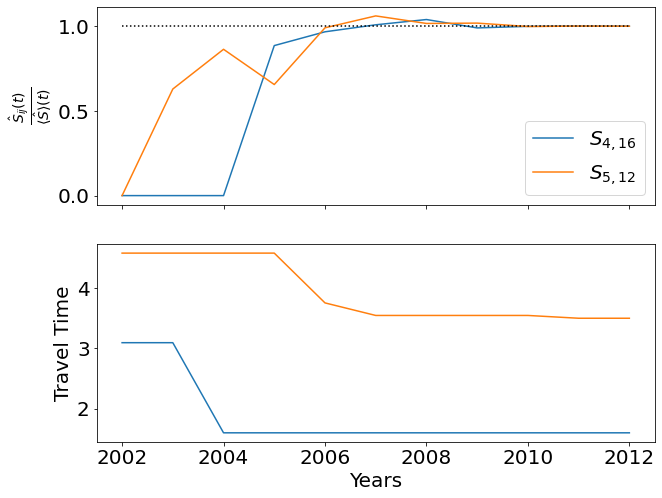

In [65]:
fig,axs=plt.subplots(figsize=(10,8),nrows=2,sharex=True)
axs[0].plot(Years,(S[:,4,16]/S[-1,4,16])/(S.mean(axis=(1,2))/S.mean(axis=(1,2))[-1]),label=r'$S_{4,16}$')
axs[0].plot(Years,(S[:,5,12]/S[-1,5,12])/(S.mean(axis=(1,2))/S.mean(axis=(1,2))[-1]),label=r'$S_{5,12}$')
axs[0].plot([2002,2012],[1,1],'k:')
axs[0].set_ylabel(r"$\frac{\hat{S}_{ij}(t)}{\langle \hat{S}\rangle(t)}$")
# axs[0].xaxis.set_ticklabels([y for y in Years[:2:]])
axs[0].legend()

axs[1].plot(Years,travel_time_tensor[:,4,16])
axs[1].plot(Years,travel_time_tensor[:,5,12])
axs[1].set_ylabel("Travel Time")
axs[1].set_xlabel("Years")
fig.savefig("../analysis/Figures/outlier_examples.png",bbox_inches='tight')

# Least-squares optimization
Will use sp.optimize.least_squares to infer gravity model parameters 

## Constant Parameters

In [15]:
n=users_per_city(W)
def gravity_model(dist,alpha=1,beta=1,gamma=2,d_0=1):
    # this will output the entire tensor
    return np.array([np.outer(n[t,:]**alpha,n[t,:]**beta)*d_0**gamma/(dist[t,:,:]**gamma) for t in range(n.shape[0])])

def residual_social_gravity(x,t,dist):
    # residual to use in sp.optimize.least_squares
    if len(x) == 3:
        d_0,gamma,alpha=x
    else:
        d_0,gamma=x
        alpha=(1,1)
    G = gravity_model(dist,d_0=d_0,gamma=gamma,alpha=alpha,beta=alpha)
    return S[mask_SL]-G[mask_SL]

In [7]:
# Gravity model 0: constant parameters, travel times
result_0 = sp.optimize.least_squares(residual_social_gravity,
                                     [1e-10,2,1],bounds=([0,1,0],[np.inf,2,2]),
                                     args=(0,travel_time_tensor)) # least-squares optimization
print(result_0.x)
d_0_0,gamma_0,alpha_0=tuple(result_0.x) 
G_0 = gravity_model(travel_time_tensor,gamma=gamma_0,d_0=d_0_0,alpha=alpha_0,beta=alpha_0)


# Gravity model 1: constant parameters, road lengths
result_1 = sp.optimize.least_squares(residual_social_gravity,
                                     [1e-10,2,1],bounds=([0,1,0],[np.inf,2,2]),
                                     args=(0,length_tensor)) # least-squares optimization
print(result_1.x)
d_0_1,gamma_1,alpha_1=tuple(result_1.x)

G_1 = gravity_model(length_tensor,gamma=gamma_1,d_0=d_0_1,alpha=alpha_1,beta=alpha_1)

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


[0.09218338 1.86267125 0.67466904]
[1.28800017 1.88949255 0.84575073]


In [8]:
print(result_0.x[0]*60)

5.531003060825077


Text(0.5, 0, 'Year')

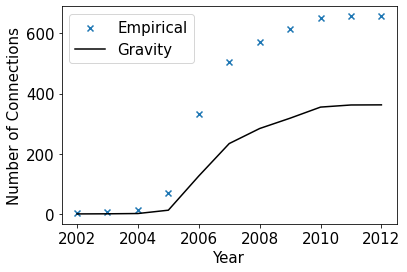

In [9]:
plt.scatter(Years,[S[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],label='Empirical',marker='x')
plt.plot(Years,[G_0[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])],label='Gravity',color='k')
plt.legend()
plt.ylabel("Number of Connections")
plt.xlabel("Year")

## Evolving parameters

In [10]:
def gravity_model_t(dist,t,alpha=1,beta=1,gamma=2,d_0=1):
    return np.outer(n[t,:]**alpha,n[t,:]**beta)*d_0**gamma/(dist[t,:,:]**gamma)

def residual_social_gravity_t(x,t,dist):
    if len(x)==3:
        d_0,gamma,alpha=x
    else:
        d_0,gamma=x
        alpha,beta=(1,1)
    G = gravity_model_t(dist,t,d_0=d_0,gamma=gamma,alpha=alpha,beta=alpha)
    return S[t,:,:][mask_SL_t]-G[mask_SL_t]

In [11]:
result_2 = [sp.optimize.least_squares(residual_social_gravity_t,
                                      [1e-10,2,1],bounds=([0,1,0],[np.inf,2,2]),
                                      args=(t,travel_time_tensor)) 
            for t in range(S.shape[0])]

result_3 = [sp.optimize.least_squares(residual_social_gravity_t,
                                      [1e-10,2,1],bounds=([0,1,0],[np.inf,2,2]),
                                      args=(t,length_tensor)) 
            for t in range(S.shape[0])]

G_2 = np.array([gravity_model_t(travel_time_tensor,t,
                                gamma=result_2[t].x[1],
                                d_0=result_2[t].x[0],alpha=result_2[t].x[2],beta=result_2[t].x[2]) 
                for t in range(S.shape[0])])

G_3 = np.array([gravity_model_t(length_tensor,t,
                                gamma=result_3[t].x[1],
                                d_0=result_3[t].x[0],alpha=result_3[t].x[2],beta=result_3[t].x[2]) 
                for t in range(S.shape[0])])

g_models = [G_0,G_1,G_2,G_3]

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [12]:
result_2_par = [np.mean([r.x[i] for r in result_2]) for i in range(3)]
print(result_2_par)

result_3_par = [np.mean([r.x[i] for r in result_3]) for i in range(3)]
print(result_3_par)

result_2_par_std = [np.std([r.x[i] for r in result_2]) for i in range(3)]
print(result_2_par_std)

result_3_par_std = [np.std([r.x[i] for r in result_3]) for i in range(3)]
print(result_3_par_std)

[0.052296316084133855, 1.7956601354496988, 0.9905413130262244]
[1.503509908333574, 1.8813424140899948, 0.8981458086740584]
[0.03347954417419905, 0.12215085275876734, 0.4939345231119504]
[0.9751431704487837, 0.1651819229794399, 0.08832120366377792]


In [13]:
result_2_par[0]*60

3.137778965048031

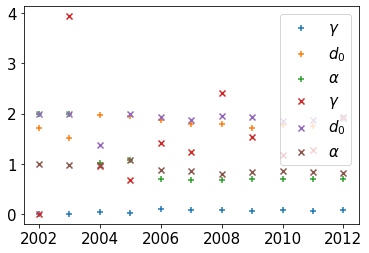

In [14]:
plt.scatter(Years,[result_2[t].x[0] for t in range(len(Years))],marker='+',label=r'$\gamma$')
plt.scatter(Years,[result_2[t].x[1] for t in range(len(Years))],marker='+',label=r'$d_0$')
plt.scatter(Years,[result_2[t].x[2] for t in range(len(Years))],marker='+',label=r'$\alpha$')

plt.scatter(Years,[result_3[t].x[0] for t in range(len(Years))],marker='x',label=r'$\gamma$')
plt.scatter(Years,[result_3[t].x[1] for t in range(len(Years))],marker='x',label=r'$d_0$')
plt.scatter(Years,[result_3[t].x[2] for t in range(len(Years))],marker='x',label=r'$\alpha$')
# plt.plot(Years,[result_2[t].x[3] for t in range(len(Years))],label=r'$\beta$')
plt.legend()

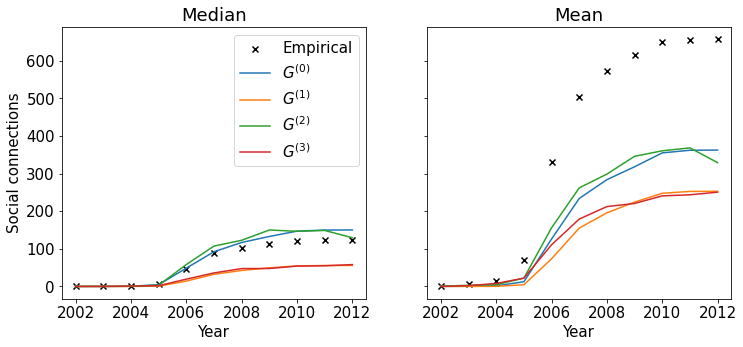

In [15]:
fig,axs=plt.subplots(figsize=(12,5),ncols=2,sharey=True)

axs[0].scatter(Years,[np.median(S[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
axs[0].plot(Years,[np.median(G_0[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(0)}$')
axs[0].plot(Years,[np.median(G_1[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(1)}$')
axs[0].plot(Years,[np.median(G_2[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(2)}$')
axs[0].plot(Years,[np.median(G_3[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(3)}$')
axs[0].set_title("Median")
axs[0].legend()

axs[1].scatter(Years,[np.mean(S[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
axs[1].plot(Years,[np.mean(G_0[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(0)}$')
axs[1].plot(Years,[np.mean(G_1[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(1)}$')
axs[1].plot(Years,[np.mean(G_2[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(2)}$')
axs[1].plot(Years,[np.mean(G_3[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$G^{(3)}$')
axs[1].set_title("Mean")

axs[0].set_ylabel("Social connections")
for i in range(2):
    axs[i].set_xlabel("Year")
    
# fig.savefig("../analysis/Figures/Gravity models.png",bbox_inches='tight')

[Text(0, 1, 'Empirical'),
 Text(0, 2, '$G^{(0)}$'),
 Text(0, 3, '$G^{(1)}$'),
 Text(0, 4, '$G^{(2)}$'),
 Text(0, 5, '$G^{(3)}$')]

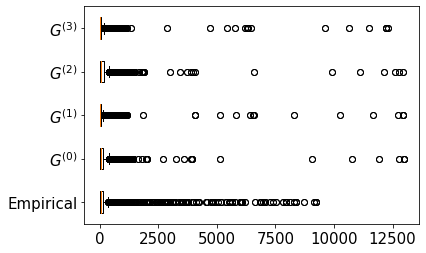

In [16]:
fig,ax = plt.subplots()
plt.boxplot((S[mask_SL],G_0[mask_SL],G_1[mask_SL],G_2[mask_SL],G_3[mask_SL]),vert=False)
ax.set_yticklabels(('Empirical',r'$G^{(0)}$',r'$G^{(1)}$',r'$G^{(2)}$',r'$G^{(3)}$'))
# plt.boxplot(G_0[mask_SL])
# plt.violinplot(S[mask_SL],vert=False)
# plt.xscale('log')
# plt.xlim([1,2e4])

# Statistical Tests

## Chi-2 test

In [17]:
def chi2(obs,exp):
    # in cases of 0 expectations
    return np.sum((obs[exp!=0]-exp[exp!=0])**2/exp[exp!=0])

def upper_triangle(tensor):
    return np.array([tensor[t,i,j] for t in range(tensor.shape[0]) for i in range(S.shape[1]) for j in range(i+1,S.shape[2])])

In [18]:
# The error here is due to null model being utterly awful
chi2_results = [sp.stats.chisquare(upper_triangle(S),upper_triangle(g)) for g in g_models]

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.9840722634881102

In [19]:
chi_values = [chi2(upper_triangle(S),upper_triangle(g)) for g in g_models]
print(chi_values)

# At 1% significance, the critical value of the chi^2 should be
print(sp.stats.chi2.ppf(1-0.01,len(upper_triangle(S))))

[3878440.831785446, 7937529.411465938, 3152742.4714364843, 1.231287937185451e+25]
2026.6211710070265


In [20]:
# Degrees of freedom = T*N*(N-1)/2 - 1
p_value = [1-sp.stats.chi2.cdf(chi,S.shape[1]*(S.shape[2]-1)*S.shape[0]/2-1) for v,chi in enumerate(chi_values)]
print(p_value)

[0.0, 0.0, 0.0, 0.0]


## Mean Percentage Error (MPE)

In [21]:
def pe(obs,exp):
    return (obs-exp)/obs

In [22]:
def mpe(obs,exp):
    return np.mean((obs[obs>0]-exp[obs>0])/obs[obs>0])
MPEs = [mpe(upper_triangle(S),upper_triangle(g))*100 for g in g_models]
print(MPEs)

[-71.0742390133378, 39.539688421118655, -73.15899324697452, 21.420903042411116]


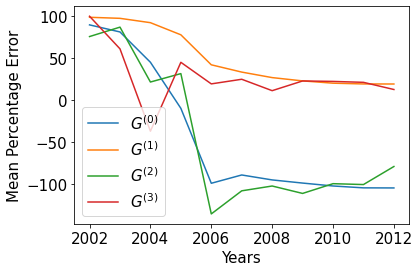

In [23]:
MPEs_t = [[mpe(S[t,:,:][mask_SL_t],g[t,:,:][mask_SL_t]) for t in range(S.shape[0])] for g in g_models]
for v in range(4):
    plt.plot(Years,np.array(MPEs_t[v])*100,label=r'$G^{(%s)}$'%v)
plt.ylabel("Mean Percentage Error")
plt.xlabel('Years')
plt.legend()

## Mean Absolute Percentage Error (MAPE)

In [24]:
def mape(obs,exp):
    return np.mean(np.abs(obs[obs>0]-exp[obs>0])/obs[obs>0])
MAPEs = [mape(S[mask_SL],g[mask_SL])*100 for g in g_models]
print(MAPEs)

[141.63418440475618, 79.48543239654504, 142.78876069689105, 81.1405995937687]


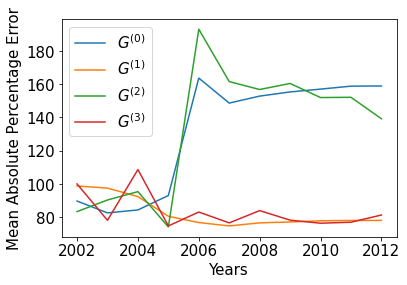

In [25]:
MAPEs_t = [[mape(S[t,:,:][mask_SL_t],g[t,:,:][mask_SL_t]) for t in range(S.shape[0])] for g in g_models]
for v in range(4):
    plt.plot(Years,np.array(MAPEs_t[v])*100,label=r'$G^{(%s)}$'%v)
plt.ylabel("Mean Absolute Percentage Error")
plt.xlabel('Years')
plt.legend()

# Radiation model

In [30]:
def radiation_model(dist,c=1):
    out = np.zeros_like(S)
    m = np.zeros_like(S)
    for t in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[2]):
                    if dist[t,i,k] <= dist[t,i,j]:
                        m[t,i,j] += n[t,k]
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                out[t,i,j] = c*S.sum(axis=2)[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
#                 out[t,i,j] = n[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
    return out

def residual_social_radiation(x,t,dist):
    R = radiation_model(dist,c=x[0])
    return S[mask_SL] - R[mask_SL]

def radiation_model_t(dist,t,c=1):
    out = np.zeros_like(S[0,:,:])
    m = np.zeros_like(S)
    for t in range(S.shape[0]):
        for i in range(S.shape[1]):
            for j in range(S.shape[2]):
                for k in range(S.shape[2]):
                    if dist[t,i,k] <= dist[t,i,j]:
                        m[t,i,j] += n[t,k]
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            out[i,j] = c*S.sum(axis=2)[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
#                 out[t,i,j] = n[t,i]*n[t,i]*n[t,j]/((n[t,i]+n[t,j]+m[t,i,j])*(n[t,i]+m[t,i,j]))
    return out

def residual_social_radiation_t(x,t,dist):
    R_t = radiation_model_t(dist,t,c=x[0])
    return S[t,:,:][mask_SL_t] - R_t[mask_SL_t]

In [31]:
# Constant parameters
result_R0 = sp.optimize.least_squares(residual_social_radiation,
                                     [1],bounds=([0],[10]),
                                     args=(0,travel_time_tensor)) # least-squares optimization
print(result_R0.x)
R_0 = radiation_model(travel_time_tensor,c=result_R0.x[0])

result_R1 = sp.optimize.least_squares(residual_social_radiation,
                                     [1],bounds=([0],[10]),
                                     args=(0,length_tensor)) # least-squares optimization
print(result_R1.x)
R_1 = radiation_model(length_tensor,c=result_R1.x[0])

[4.16892147]
[4.1951108]


In [33]:
#Evolving parameters
result_R2 = [sp.optimize.least_squares(residual_social_radiation_t,
                                      [1],bounds=([0],[np.inf]),
                                      args=(t,travel_time_tensor)) 
            for t in range(S.shape[0])]

result_R3 = [sp.optimize.least_squares(residual_social_radiation_t,
                                      [1],bounds=([0],[np.inf]),
                                      args=(t,length_tensor)) 
            for t in range(S.shape[0])]

In [34]:
R_2 = np.array([radiation_model_t(travel_time_tensor,t,c=result_R2[t].x[0]) 
                for t in range(S.shape[0])])

R_3 = np.array([radiation_model_t(length_tensor,t,c=result_R3[t].x[0]) 
                for t in range(S.shape[0])])

r_models = [R_0,R_1,R_2,R_3]

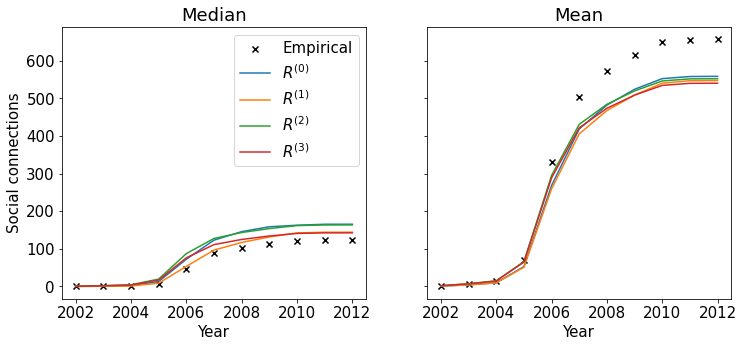

In [35]:
fig,axs=plt.subplots(figsize=(12,5),ncols=2,sharey=True)

axs[0].scatter(Years,[np.median(S[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
axs[0].plot(Years,[np.median(R_0[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(0)}$')
axs[0].plot(Years,[np.median(R_1[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(1)}$')
axs[0].plot(Years,[np.median(R_2[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(2)}$')
axs[0].plot(Years,[np.median(R_3[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(3)}$')
axs[0].set_title("Median")
axs[0].legend()

axs[1].scatter(Years,[np.mean(S[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='Empirical',marker='x',color='k')
axs[1].plot(Years,[np.mean(R_0[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(0)}$')
axs[1].plot(Years,[np.mean(R_1[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(1)}$')
axs[1].plot(Years,[np.mean(R_2[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(2)}$')
axs[1].plot(Years,[np.mean(R_3[t,:,:][mask_SL_t]) for t in range(S.shape[0])],label='$R^{(3)}$')
axs[1].set_title("Mean")

axs[0].set_ylabel("Social connections")
for i in range(2):
    axs[i].set_xlabel("Year")
    
fig.savefig("../analysis/Figures/Radiation models.png",bbox_inches='tight')

# Chi^2 test

In [36]:
# The error here is due to null model being utterly awful
chi2_Rresults = [sp.stats.chisquare(upper_triangle(S),upper_triangle(r)) for r in r_models]

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.10164278811965224

In [37]:
chi_Rvalues = [chi2(upper_triangle(S),upper_triangle(r)) for r in r_models]
print(chi_Rvalues)

# At 1% significance, the critical value of the chi^2 should be
print(sp.stats.chi2.ppf(1-0.01,len(upper_triangle(S))))

[768951.6, 870992.2, 787683.75, 834594.25]
2026.6211710070265


In [43]:
MPEs_R = [mpe(upper_triangle(S),upper_triangle(r))*100 for r in r_models]
print(MPEs_R)

[-3.6881056, -2.6972392, -4.1576796, -3.1751916]


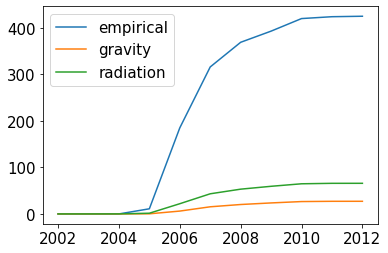

In [60]:
plt.plot(Years,S[:,1,10],label='empirical')
plt.plot(Years,G_1[:,1,10],label='gravity')
plt.plot(Years,R_1[:,1,10],label='radiation')
plt.legend()